# Solar Supply Forecast in South Australia: Sketch

---

This project aims to forecast energy supply from solar photovoltaic (PV) in South Australia. This is my first attempt at exploring Energy and Environmental topic, and may yield useful information to anticipate potential grid volatility.


## Exploratory Data Analysis

The file `etl_out.csv` has been extracted from OpenNEM and Open Meteo's API via `etl.py`, sampling daily data from 5 January 2019 to 5 January 2024 for various solar plants in South Australia.

Due to the regularly-flowing nature of the data, I do not set aside final test data from our training data.

Below is the code for generating preliminary plots:

/home/rotisayabundar/.local/lib/python3.8/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/rotisayabundar/.local/lib/python3.8/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


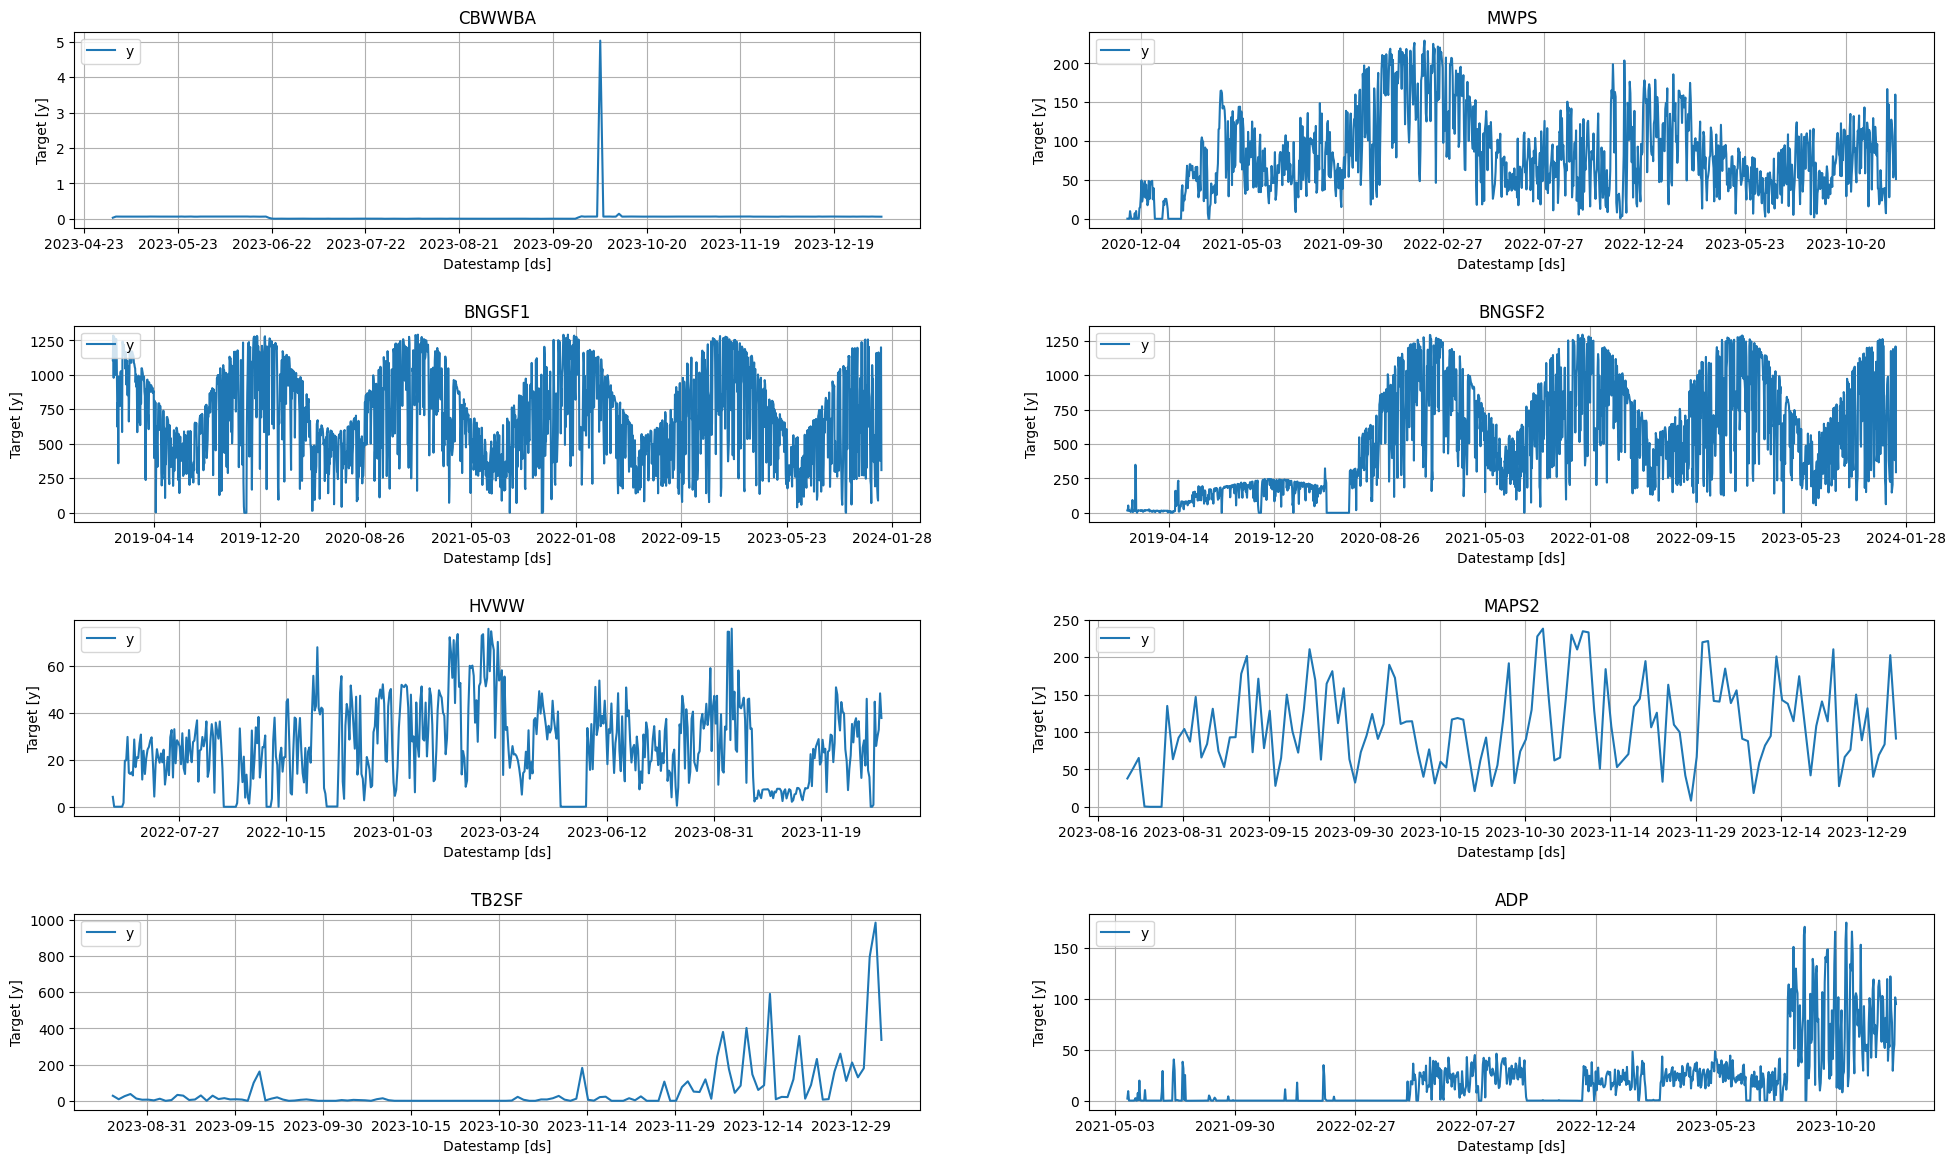

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import Naive, WindowAverage, AutoETS, AutoARIMA, CrostonOptimized
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from mlforecast import MLForecast # LGBM potentially?
import lightgbm as lgb
from statsforecast.utils import ConformalIntervals

from os.path import isfile
import pickle

# Import data, no set aside test data (let the real data shows it)
sol = pd.read_csv("data/etl_out.csv")

# Select the data from establishment dates (actually should be in ETL)
for name in sol["Name"].unique():
    start_date_idx = sol[sol["Name"] == name].index[0]
    est_date_idx = sol[(sol["Name"] == name) & (sol["Energy"] > 0)].index[0]
    sol.drop(index = list(range(start_date_idx, est_date_idx)), inplace=True)

# Change header for modelling library
sol_sf = sol[["Name", "Date", "Energy", "Temperature", "Solar Irradiance"]] \
                .replace("", np.nan).dropna() \
                .rename(columns = {
                    "Name": "unique_id",
                    "Date": "ds",
                    "Energy": "y"
                })

# Model
models = [Naive(), WindowAverage(7), AutoETS(), AutoARIMA(), CrostonOptimized()]
ml_models = [lgb.LGBMRegressor(verbosity=-1)]

sf = StatsForecast(models, freq="D", df=sol_sf)
mlf = MLForecast(ml_models, freq="D")

# Plot
sf.plot(sol_sf[["unique_id", "ds", "y"]])

Several impressions:

* The data is very volatile. Sudden hike and dive, but obviously capped from above (by plant capacities). On the other hand, there is not too much data per series (less than 2000 points), so classical statistical modelling can work extremely well. (Unless I mine the hourly results. Which is possible, but harder to reason). It seems that seasonal-trend decomposition would be multiplicative.


* `BNGSF1, BNGSF2, TBSF, MWPS` span more than 4 years with sinusonial annual seasonality. This might give raise to trigonometric transformation (maybe TBATS).


* `HVWW` and `PAREPW` have been active for 1-2 years.


* Some plants have zero outputs for several days. This might be less about weather performance, and might have to do with grid stability or some population-related issues.


* `BOLIVAR` and `ADP` have a sudden spike in activities. Might need to research more of what is happening.


* `MAPS2` (might be a mislabeled from Mannum's `MANN`) is pretty new (< 1 year). As well as plants `MBPS2` and `TB2SF`, marked with `2` suffix, are related to their primary plants, so I am thinking of predicting both areas at once.


* `CBWWBA` is *essentially zero*.

## Time Series Modeling

We will use several time series models such as baseline models (naive model, window average (7 days)); statistical models such autoregressive integrated moving average (ARIMA, max p, q = 5) with temperature and solar irradiance as exogenous factors, exponential smoothing (ETS), and Croston's method which may be able to handle intermmitent series; as well as ensemble models.

Machine learning models such as LightGBM are being considered in the future. Feature engineering 


Advanced machine learning methods such as LSTM are excluded because their primary Python implementation `TensorFlow` ideally requires an additional graphic card requirement which not everyone will necessarily be able to afford. However, PyTorch and others are still in open.

We use MSE and MAPE as accuracy metrics for our models.

## Cross Validation

The current cross validation implementation is a simple forward chain, with 30-day steps (i.e. monthly) for shorter series and 90-day steps (i.e. quarter yearly) for longer series.

I want to implement rolling windows.


In [2]:
# === Cross-validation
# For simplicity, load the objects from Pickle

h = 7
ds_limit = 500
if not isfile("data/cv_obj.pkl"):
    # Nixtla's results
    cvs = []
    for unique_id in sol_sf["unique_id"].unique():
        sol_ = sol_sf[sol_sf["unique_id"] == unique_id]
        # Separated based on short vs long time series
        step = 90 if len(sol_) > ds_limit else 30
        n_windows = min(np.floor(len(sol_)/step).astype(int), 10)
        intervals = ConformalIntervals(h=h, n_windows=n_windows)
        cv_ = sf.cross_validation(df=sol_, h=h, n_windows=n_windows, step_size=step, level=[90], prediction_intervals=intervals).reset_index()
        cvs.append(cv_)
    cvs = pd.concat(cvs)
    cvs["h"] = (cvs["ds"] - cvs["cutoff"]).dt.days
    # Ensemble result
    cvs["EnsembleFreaky"] = (cvs["AutoARIMA"] + cvs["WindowAverage"])/2
    cvs["EnsembleAll"] = cvs.loc[:, "Naive":"CrostonOptimized"].mean(axis=1)

    with open('data/cv_obj.pkl', 'wb') as outp:
        pickle.dump(cvs, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open('data/cv_obj.pkl', 'rb') as inp:
        cvs = pickle.load(inp)

In [4]:
# === Accuracy

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mse #mase soon

def evaluate_cv(df, metrics): #Simplify soon?
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y', 'h']).columns.tolist()
    evals = []
    for cutoff in df['cutoff'].unique():
        df_smp = df[df['cutoff'] == cutoff]
        for h in df_smp['h'].unique():
            df_smp_smp = df_smp[df_smp['h'] == h]
            eval_ = evaluate(df_smp_smp, metrics=metrics, models=models)
            eval_['h'] = h
            evals.append(eval_)
    # SOON: weight based on number of training samples?
    evals = pd.concat(evals)
    evals = evals.groupby(["unique_id", "metric", "h"]).mean(numeric_only=True)
    evals['best_model'] = evals.idxmin(axis=1)
    return evals.reset_index()

# The Auto function has been based on grid search using AIC so AIC/BIC not included
errors = evaluate_cv(cvs.drop('SeasonalNaive', axis=1), [mape, mse])
print(errors)

    unique_id metric  h          Naive            RWD  WindowAverage  \
0         ADP   mape  1       0.501361       0.513540      11.073941   
1         ADP   mape  2       1.676691       1.704921      12.216711   
2         ADP   mape  3       0.842676       0.876805      11.738719   
3         ADP   mape  4       0.654932       0.704491      11.784151   
4         ADP   mape  5       0.208392       0.259886      11.245638   
..        ...    ... ..            ...            ...            ...   
163      TBSF    mse  3  178280.031250  178413.109375  118489.765625   
164      TBSF    mse  4   57200.289062   57304.832031   31192.691406   
165      TBSF    mse  5   72822.835938   73026.000000   47903.359375   
166      TBSF    mse  6   51830.757812   51940.316406   46513.523438   
167      TBSF    mse  7   85362.062500   85167.921875   40952.683594   

        AutoTheta       AutoETS     AutoARIMA  CrostonOptimized  \
0        7.595885      7.610939     11.174474          9.626104   
1

In [6]:
# This should actually be best models that new samples can fit
#   not just taking model's last result

final = cvs[cvs["cutoff"] == cvs.groupby("unique_id")["cutoff"].transform(max)]
final = final.merge(errors[errors['metric'] == "mse"][["unique_id", "best_model", "h"]], \
                    on=["unique_id", "h"], how="outer")
final = final.melt(id_vars = ["unique_id", "ds", "best_model"])
preds = final[final["best_model"] == final["variable"]] \
            .drop(columns="variable") \
            .sort_values(by = ["unique_id", "ds"]) \
            .rename(columns = {"value": "y"})
hists = sol_sf

print(preds)

     unique_id                  ds        best_model           y
1022       ADP 2023-12-28 04:00:00       EnsembleAll   85.692978
1023       ADP 2023-12-29 04:00:00       EnsembleAll    82.77713
1024       ADP 2023-12-30 04:00:00       EnsembleAll    80.79567
1025       ADP 2023-12-31 04:00:00       EnsembleAll   83.371994
438        ADP 2024-01-01 04:00:00     WindowAverage   75.729141
...        ...                 ...               ...         ...
716       TBSF 2023-12-30 04:00:00         AutoARIMA  261.927917
801       TBSF 2023-12-31 04:00:00  CrostonOptimized   308.71051
634       TBSF 2024-01-01 04:00:00           AutoETS  307.741028
719       TBSF 2024-01-02 04:00:00         AutoARIMA  475.466858
972       TBSF 2024-01-03 04:00:00    EnsembleFreaky  222.354523

[84 rows x 4 columns]


In [ ]:
# Try generating Optimal Ensemble

from scipy.optimize import minimize, Bounds

def regularised_sum_se(w, y, X, a):
    return np.linalg.norm(y - X @ w)**2 + a*np.linalg.norm(w)**2

curr_loc = "ADP"
curr_h = 1
y = cv_sol_sf.loc[(cv_sol_sf["unique_id"] == curr_loc) & (cv_sol_sf["h"] == curr_h), "y"]
X = cv_sol_sf.loc[(cv_sol_sf["unique_id"] == curr_loc) & (cv_sol_sf["h"] == curr_h), "Naive":"CrostonOptimized"]
w0 = np.array(8*[1]) / 8
a = 0.5
bound = Bounds(8 * [0], 8 * [1])
cons = {"type" : "eq", "fun": lambda w: np.sum(w) - 1}
        
res = minimize(lambda w: regularised_sum_se(w, y, X, a), w0, bounds=bound, constraints=cons, options={'disp': True})
res